# Multivariate Time Series Forecasting of Energy Consumption
### Final Project - Deep Learning - MSDS 5011

## Description of Data and Problem: 
Features: Hourly averages of several related variables, including: Ambient Temperature (AT), Exhaust Vacuum (V), Ambient Pressure (AP), and Relative Humidity (RH). 

Goal: Predict PE (consumption) using AT, V, AP, and RH and to justify using Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) models.

The data points are hourly averages collected over 6 years (2006-2011) and are already sorted chronologically, which should make it easy to create time window/sequences for an LSTM/GRU model.

This problem is a good choice for deep learning because energy consumption often has complex, non-linear dependencies on external factors and long-term historical trends.  We will look at two Recurrent Neural Networks (RNNs), specifically LSTM and GRU networks.  Both excel at modeling these long-term dependencies and sequential data.

Deep learning architectures handle multiple input series well by learning the interaction between different features.

Forecasting is a regression problem with clear metrics like Mean Squared Error (MSE) or Mean Absolute Error (MAE).

Data Source is the UCI Combined Cycle Power Plant Data Set can be found here: https://www.kaggle.com/datasets/prateekmaj21/uci-ml-combined-cycle-power-plant-data-set


In [1]:
# Check file path for import from Kaggle
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/uci-ml-combined-cycle-power-plant-data-set/Folds5x2_pp.csv


In [2]:
# read in data from kaggle folder
df = pd.read_csv("/kaggle/input/uci-ml-combined-cycle-power-plant-data-set/Folds5x2_pp.csv")

In [3]:
# data size, dimension, structure, etc...
print(f"Dimensions (Rows, Columns): {df.shape}")
print(f"Total elements: {df.size}")

df.info()
print("\nData Types per Column:\n", df.dtypes)
print("\nFirst 3 rows:\n", df.head(3))

# Check for missing values
print("\nMissing values per column:\n", df.isnull().sum())

Dimensions (Rows, Columns): (47844, 5)
Total elements: 239220
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47844 entries, 0 to 47843
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   AT      47844 non-null  object
 1   V       47844 non-null  object
 2   AP      47844 non-null  object
 3   RH      47844 non-null  object
 4   PE      47844 non-null  object
dtypes: object(5)
memory usage: 1.8+ MB

Data Types per Column:
 AT    object
V     object
AP    object
RH    object
PE    object
dtype: object

First 3 rows:
       AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11   39.4  1012.16  92.14  488.56

Missing values per column:
 AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64


Observations: We have 47,844 rows of data for a total of 239,220 elements and no missing values.

In [4]:
# Convert all columns to numeric values
numeric_cols = ['AT', 'V', 'AP', 'RH', 'PE']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(df.dtypes)

# Check for Missing Values again.
print("\nNew Missing Value Check After Coercion")
print(df.isnull().sum())

AT    float64
V     float64
AP    float64
RH    float64
PE    float64
dtype: object

New Missing Value Check After Coercion
AT    4
V     4
AP    4
RH    4
PE    4
dtype: int64


In [5]:
# drop the new NaN values
df.dropna(inplace=True)

print("\n--- Data Types After Conversion ---")
print(df.dtypes)


--- Data Types After Conversion ---
AT    float64
V     float64
AP    float64
RH    float64
PE    float64
dtype: object


## EDA Procedure
The UCI data is chronologically ordered but lacks an explicit datetime column, so we'll treat the row index as the time step for initial visualization.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

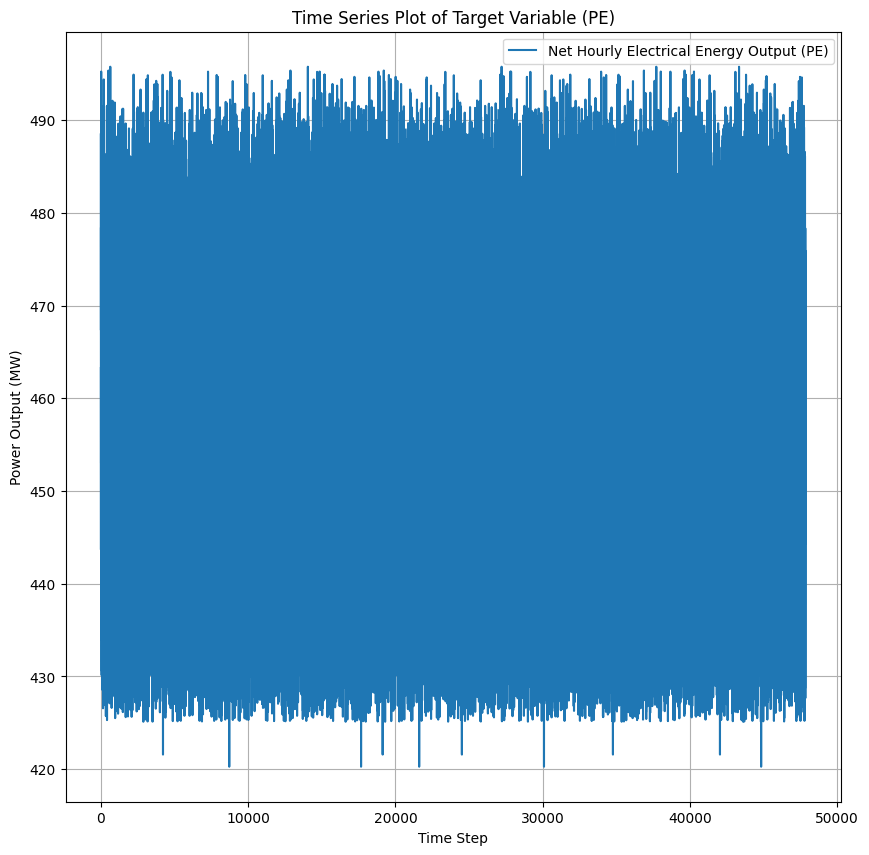

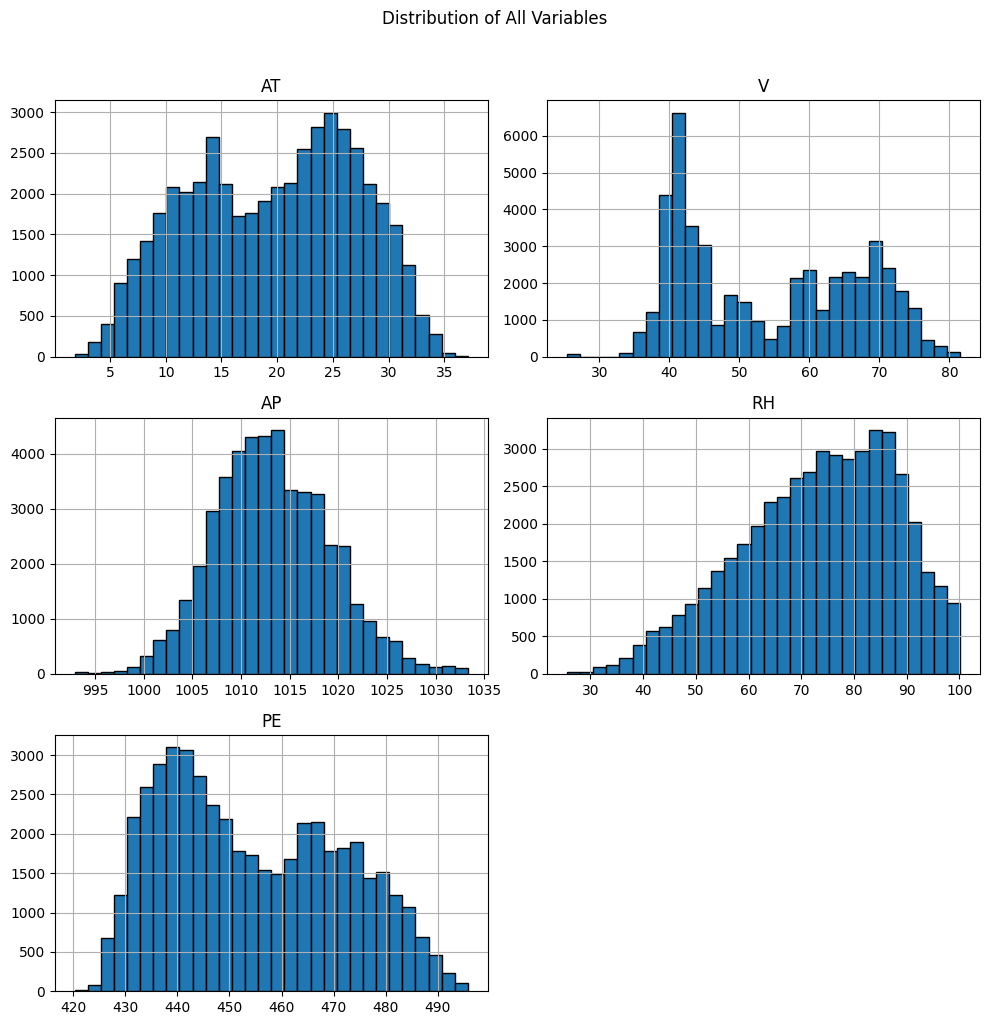

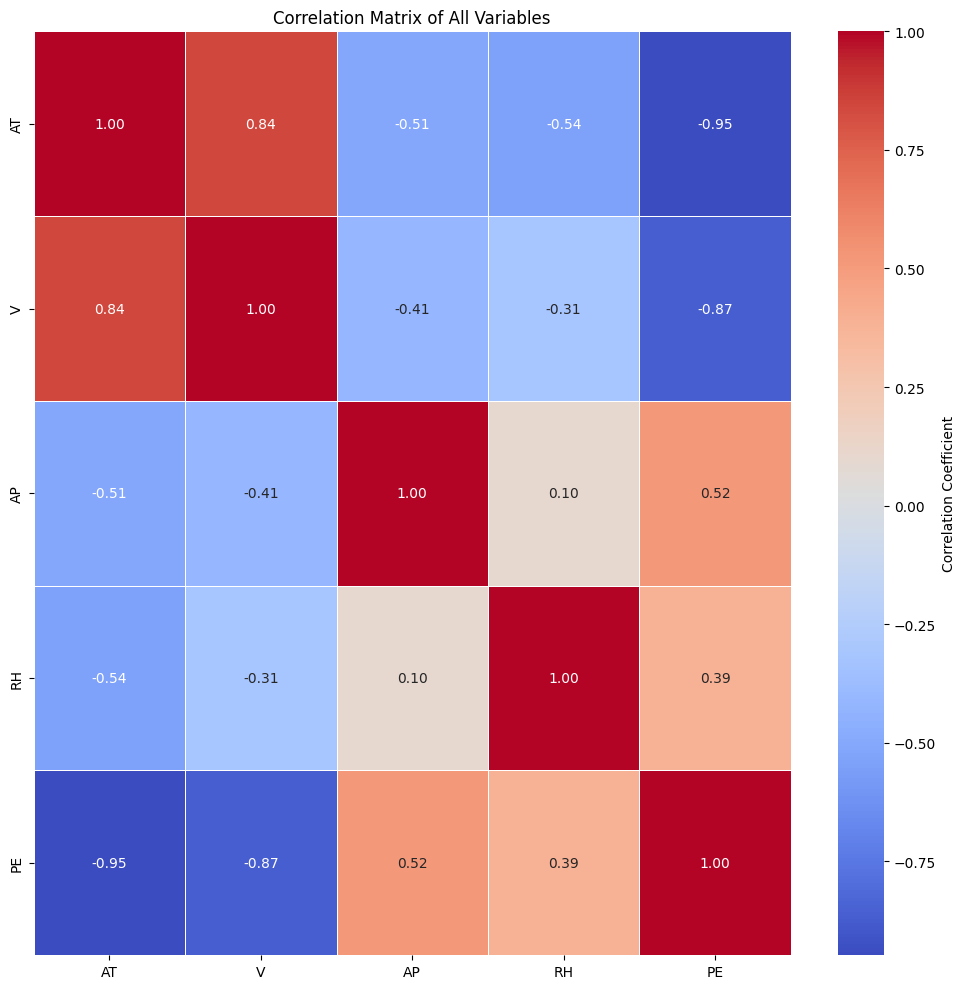

In [7]:
# Time Series Visualization of Target Variable
# Plots PE against the index.  
plt.figure(figsize=(10,10))
plt.plot(df.index, df['PE'], label = 'Net Hourly Electrical Energy Output (PE)')
plt.title('Time Series Plot of Target Variable (PE)')
plt.xlabel('Time Step')
plt.ylabel('Power Output (MW)')
plt.grid(True)
plt.legend()
plt.show()

# Distribution of Features
# Plot histograms to see the spread and shape of each variable.
df.hist(figsize=(10, 10), bins=30, edgecolor='black')
plt.suptitle('Distribution of All Variables', y=1.02)
plt.tight_layout()

# Heatmap of the correlation matrtix.  PE is most important, highlights which features have the strongest
# linear relationship with target variable.  
correlation_matrix = df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,          
    cmap='coolwarm',     
    fmt=".2f",           
    linewidths=.5,       
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Matrix of All Variables')
plt.tight_layout()
plt.show()

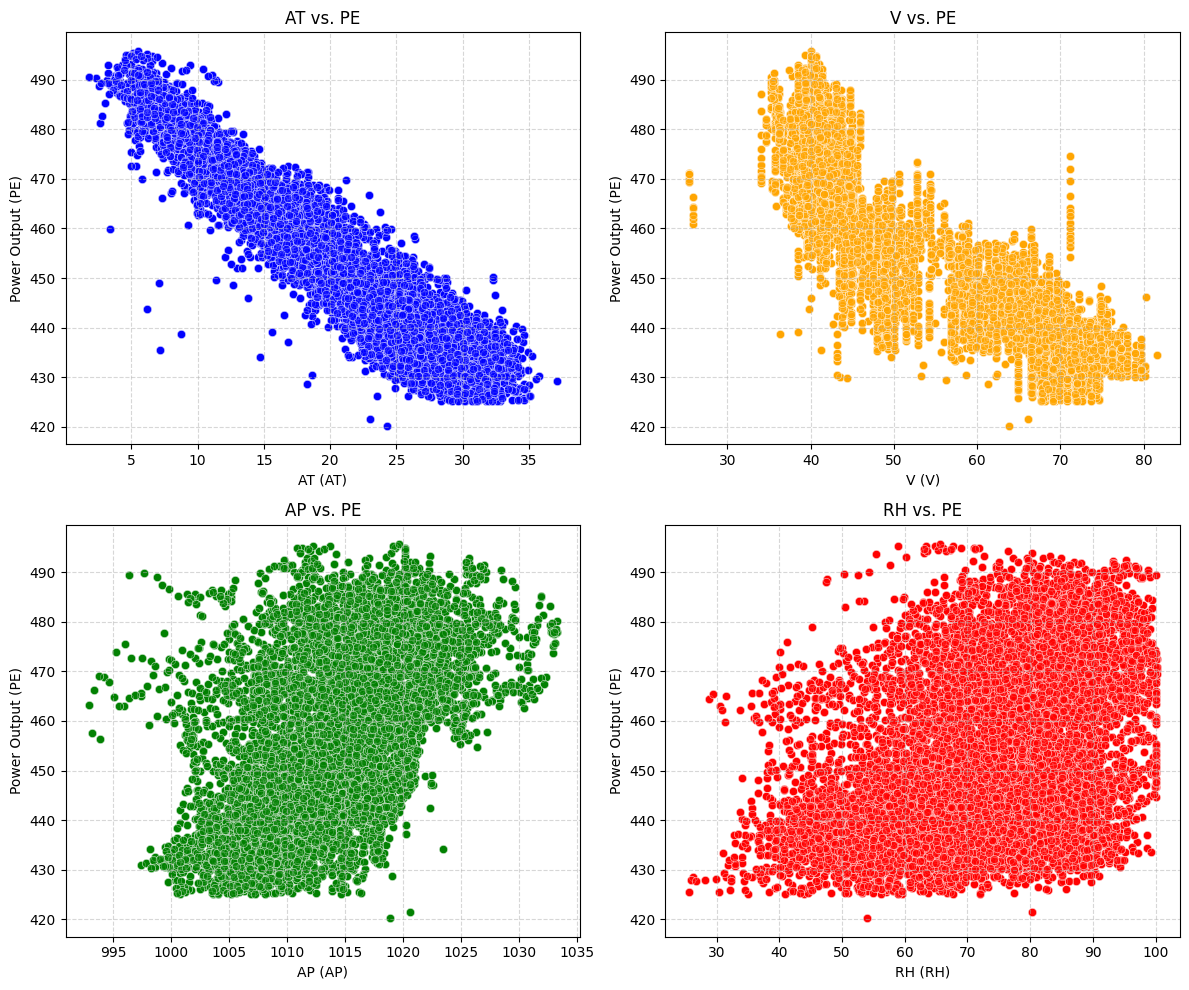

In [8]:
# Relationship between Features and Target (PE)
# Scatter plots to visualize the relationship between key features and the target.
# Use a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten() 

# Define the features to plot
features = ['AT', 'V', 'AP', 'RH']
colors = ['blue', 'orange', 'green', 'red']

# Loop through the features and plot 
for i, feature in enumerate(features):
    sns.scatterplot(x=feature, y='PE', data=df, ax=axes[i], alpha=0.6, color=colors[i])
    axes[i].set_title(f'{feature} vs. PE')
    axes[i].set_xlabel(f'{feature} ({feature})')
    axes[i].set_ylabel('Power Output (PE)')
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Observations: AT and V have the strongest relationship to PE (negative). AP and RH appear to have positive correlation but less so.  We can see there might be some complex relationship to be captured better by a deep learning model than a simple linear one.

## Cleaning and Preprocessing

### Missing Values
Earlier, we cleaned up NaN values created when coercing the data to numeric values.  Those 4 rows were dropped since the number was small.

### Feature Engineering
The original dataset doesn't have explicit timestamp column, so we need to create one.
This data is choronologically ordered hourly data, so we can create a synthetic time index.

Using a standard integer for time will mislead a model since the distance between 23 and 0 is 1 hour in reality, but is 23 if encoded using integers.

Therefore, we'll use Sine and Cosine Encoding to create a time index.

In [9]:
import math

In [10]:
# use a 24 hour lagged value of PE (sometimes this can help time series analysis)
df['PE_lag_24'] = df['PE'].shift(24)
df.dropna(inplace=True)

In [11]:
# Assuming the data starts at hour 0 - arbitrary starting point (data card says 2006-2011)
start_date = '2006-01-01 00:00:00'
frequency = 'h'

datetime_index = pd.date_range(
    start=start_date,
    periods=len(df),
    freq=frequency
)

df.set_index(datetime_index, inplace=True)

# Extract and Encode the 'Hour' feature
df['hour'] = df.index.hour

# Encode the hour cyclically (24 hours in a day)
df['hour_sin'] = np.sin(2 * math.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * math.pi * df['hour'] / 24)

# Select the final features (X) and the target (y)
features = ['AT', 'V', 'AP', 'RH', 'hour_sin', 'hour_cos', 'PE_lag_24']
target = ['PE']

data = df[features + target]
print("Data with Engineered Time Feature")
print(data.head())

Data with Engineered Time Feature
                        AT      V       AP     RH  hour_sin  hour_cos  \
2006-01-01 00:00:00  27.36  48.60  1003.18  54.93  0.000000  1.000000   
2006-01-01 01:00:00  27.47  70.72  1009.97  74.62  0.258819  0.965926   
2006-01-01 02:00:00  14.60  39.31  1011.11  72.52  0.500000  0.866025   
2006-01-01 03:00:00   7.91  39.96  1023.57  88.44  0.707107  0.707107   
2006-01-01 04:00:00   5.81  35.79  1012.14  92.28  0.866025  0.500000   

                     PE_lag_24      PE  
2006-01-01 00:00:00     463.26  436.06  
2006-01-01 01:00:00     444.37  443.25  
2006-01-01 02:00:00     488.56  464.16  
2006-01-01 03:00:00     446.48  475.52  
2006-01-01 04:00:00     473.90  484.41  


### Train-Test Split and Data Scaling (Normalization)
LSTMs perform much better and converge faster when input features are on a similar scale.  We'll fit a scaler only on the training data to prevent data leakage.  The fitted scaler will then be used to transform the training, validation, and test sets.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# can't use random splitting, must be split chronologically.  test data comes after train data.
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# data leakage prevention 
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Scale features 
train_scaled_X = scaler_X.fit_transform(train_data[features])
test_scaled_X = scaler_X.transform(test_data[features])

# Scale target 
train_scaled_y = scaler_y.fit_transform(train_data[target])
test_scaled_y = scaler_y.transform(test_data[target])

print(f"\nTraining Data Length: {len(train_data)}")
print(f"Test Data Length: {len(test_data)}")


Training Data Length: 38252
Test Data Length: 9564


### Sequence Generation Function
Sliding window technique, look back window length 24 dictates the length of the sequence that the LSTM will use to make a prediction.

return data in 3D format that is required as input for LSTM and GRU layer in Keras/Tensorflow.

In [13]:
def create_sequences(X, y, look_back):
    X_sequences, y_targets = [], []
    
    # We iterate until the start of the last possible sequence
    for i in range(len(X) - look_back):
        # Input sequence: X[i] up to X[i + look_back - 1]
        seq = X[i:(i + look_back), :]
        X_sequences.append(seq)
        
        # Target: The value at the next time step (i + look_back)
        target_val = y[i + look_back, 0] # [0] because y is 2D with 1 column
        y_targets.append(target_val)
        
    return np.array(X_sequences), np.array(y_targets)

LOOK_BACK = 24

# Apply sequence generation to the scaled data
X_train, y_train = create_sequences(train_scaled_X, train_scaled_y, LOOK_BACK)
X_test, y_test = create_sequences(test_scaled_X, test_scaled_y, LOOK_BACK)

print("\nFinal Data Shapes")
print(f"X_train shape (samples, timesteps, features): {X_train.shape}")
print(f"y_train shape (samples, target): {y_train.shape}")
print(f"X_test shape (samples, timesteps, features): {X_test.shape}")
print(f"y_test shape (samples, target): {y_test.shape}")


Final Data Shapes
X_train shape (samples, timesteps, features): (38228, 24, 7)
y_train shape (samples, target): (38228,)
X_test shape (samples, timesteps, features): (9540, 24, 7)
y_test shape (samples, target): (9540,)


## RNN Model Building and Training
define, compile, and train two RNN models as described previously.  

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Define the input shape required for the RNN layers: (timesteps, features)
INPUT_SHAPE = (X_train.shape[1], X_train.shape[2])

# Define common hyperparameters
EPOCHS = 25
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# Define the LR Scheduler
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,           
    patience=3,           
    min_lr=0.00001,       
    verbose=1
)

2025-11-17 20:19:58.294541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763410798.476012      87 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763410798.525313      87 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

### LSTM Model
3-layer Architecture and Training

In [15]:
# Define model architecture
def build_lstm_model(input_shape):
    model = Sequential([
        # 1. Input Layer: Defines the expected shape of the input data
        Input(shape=input_shape, name='Input_Layer'),
        
        # 2. First RNN Layer: No need to pass input_shape here anymore
        LSTM(units=100, return_sequences=True, name='LSTM_1'),
        Dropout(0.2),
        
        # 3. Second RNN Layer
        LSTM(units=100, return_sequences=True, name='LSTM_2'),
        Dropout(0.2),

        # Third RNN Layer
        LSTM(units=100, name='LSTM_3'),
        Dropout(0.2),
        
        # 4. Output Layer
        Dense(units=1, activation='linear', name='Output')
    ])
    
    # Compile the model
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

lstm_model = build_lstm_model(INPUT_SHAPE)
lstm_model.summary()

I0000 00:00:1763410812.997265      87 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763410812.997911      87 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 24, 100)        │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 24, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,101 (797.27 KB)

 Trainable params: 204,101 (797.27 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the model
# Define callbacks for training control
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
    ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=0),
    lr_schedule
]

print("\nTraining LSTM Model")
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1, 
    callbacks=callbacks,
    verbose=1
)


Training LSTM Model
Epoch 1/25


I0000 00:00:1763410818.113737     140 cuda_dnn.cc:529] Loaded cuDNN version 90300


538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0597 - mae: 0.2058 - val_loss: 0.0533 - val_mae: 0.1956 - learning_rate: 0.0010
Epoch 2/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0526 - mae: 0.1978 - val_loss: 0.0507 - val_mae: 0.1957 - learning_rate: 0.0010
Epoch 3/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0521 - mae: 0.1976 - val_loss: 0.0514 - val_mae: 0.1951 - learning_rate: 0.0010
Epoch 4/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0522 - mae: 0.1970 - val_loss: 0.0511 - val_mae: 0.1953 - learning_rate: 0.0010
Epoch 5/25
534/538 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0516 - mae: 0.1966
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0516 - mae: 0.1966 - val_loss: 0.0507 - val_mae: 0.1968 - learning_rate: 0.0010
Epoch 6/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0515 - mae: 0.1967 - val_loss: 0.0507 - val_mae: 0.1962 - learning_rate: 5.0000e-04
Epoch 7

### Gated Recurrent Unit (GRU) Model
simpler, more computationally efficient variant of LSTMs, often performing comparably well, especially on smaller datasets (less parameters to train).

In [17]:
# GRU Architecture
def build_gru_model(input_shape):
    model = Sequential([
        # First GRU layer: returns sequences for the next GRU layer
        GRU(units=100, return_sequences=True, input_shape=input_shape, name='GRU_1'),
        Dropout(0.2),
        
        # Second GRU layer: returns sequences for the next GRU layer
        GRU(units=100, return_sequences=True, name='GRU_2'),
        Dropout(0.2),

        # Third GRU layer: feeds directly to Dense layer
        GRU(units=100, name='GRU_3'),
        Dropout(0.2),
        
        # Output layer for regression
        Dense(units=1, activation='linear', name='Output')
    ])
    
    # Compile the model
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

gru_model = build_gru_model(INPUT_SHAPE)
gru_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ GRU_1 (GRU)                     │ (None, 24, 100)        │        32,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_2 (GRU)                     │ (None, 24, 100)        │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_3 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,001 (601.57 KB)

 Trainable params: 154,001 (601.57 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train GRU
# Define callbacks for training control
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
    ModelCheckpoint('best_gru_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=0),
    lr_schedule
]

print("\n--- Training GRU Model ---")
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)


--- Training GRU Model ---
Epoch 1/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0602 - mae: 0.2072 - val_loss: 0.0510 - val_mae: 0.1968 - learning_rate: 0.0010
Epoch 2/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0524 - mae: 0.1977 - val_loss: 0.0507 - val_mae: 0.1957 - learning_rate: 0.0010
Epoch 3/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0516 - mae: 0.1964 - val_loss: 0.0508 - val_mae: 0.1971 - learning_rate: 0.0010
Epoch 4/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0520 - mae: 0.1972 - val_loss: 0.0508 - val_mae: 0.1967 - learning_rate: 0.0010
Epoch 5/25
535/538 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0523 - mae: 0.1979
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0523 - mae: 0.1979 - val_loss: 0.0510 - val_mae: 0.1955 - learning_rate: 0.0010
Epoch 6/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0512 - mae: 0.1957 - val_loss: 0.0510 - val_mae: 0.195

## Evaluation and Tuning
Use the best saved models to predict values on the test set. (saved as best_lstm_model.keras and best_gru_model.keras)

We must inverse transform the predictions and the actual test values using 'scaler_y' that we fitted earlier to get the results back intot he original MW units.

Then, we calculate the final MSE and MAE on the inverse-scaled predictions.

The look back window size, units in the RNN layers, Learning Rate, and number of layers are all tunable hyperparameters that we can experiment with to try to beat the baseline performance.

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model

In [20]:
best_lstm = load_model('best_lstm_model.keras')
best_gru = load_model('best_gru_model.keras')

# LSTM Predictions
lstm_predicted_scaled = best_lstm.predict(X_test)

# GRU Predictions
gru_predicted_scaled = best_gru.predict(X_test)

299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [21]:
# use the fitted scaler_y to revert the data back to its original scale
# Inverse transform the predicted values
lstm_predictions = scaler_y.inverse_transform(lstm_predicted_scaled)
gru_predictions = scaler_y.inverse_transform(gru_predicted_scaled)

# Inverse transform the actual test values (y_test)
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Flatten the arrays for easier comparison and plotting
lstm_predictions = lstm_predictions.flatten()
gru_predictions = gru_predictions.flatten()
y_test_actual = y_test_actual.flatten()

# Ensure all arrays have the same length after sequence generation
assert len(lstm_predictions) == len(y_test_actual)

In [22]:
# Evaluate Performance Metrics
def calculate_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n--- {model_name} Performance on Test Set (MW) ---")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R²): {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

lstm_metrics = calculate_metrics(y_test_actual, lstm_predictions, "LSTM Model")
gru_metrics = calculate_metrics(y_test_actual, gru_predictions, "GRU Model")


--- LSTM Model Performance on Test Set (MW) ---
Mean Squared Error (MSE): 291.24
Root Mean Squared Error (RMSE): 17.07
Mean Absolute Error (MAE): 14.86
R-squared (R²): -0.0005

--- GRU Model Performance on Test Set (MW) ---
Mean Squared Error (MSE): 291.29
Root Mean Squared Error (RMSE): 17.07
Mean Absolute Error (MAE): 14.87
R-squared (R²): -0.0007


Observations: we can see that these models are not really making any improvements beyond the initial epochs.  More on this below.

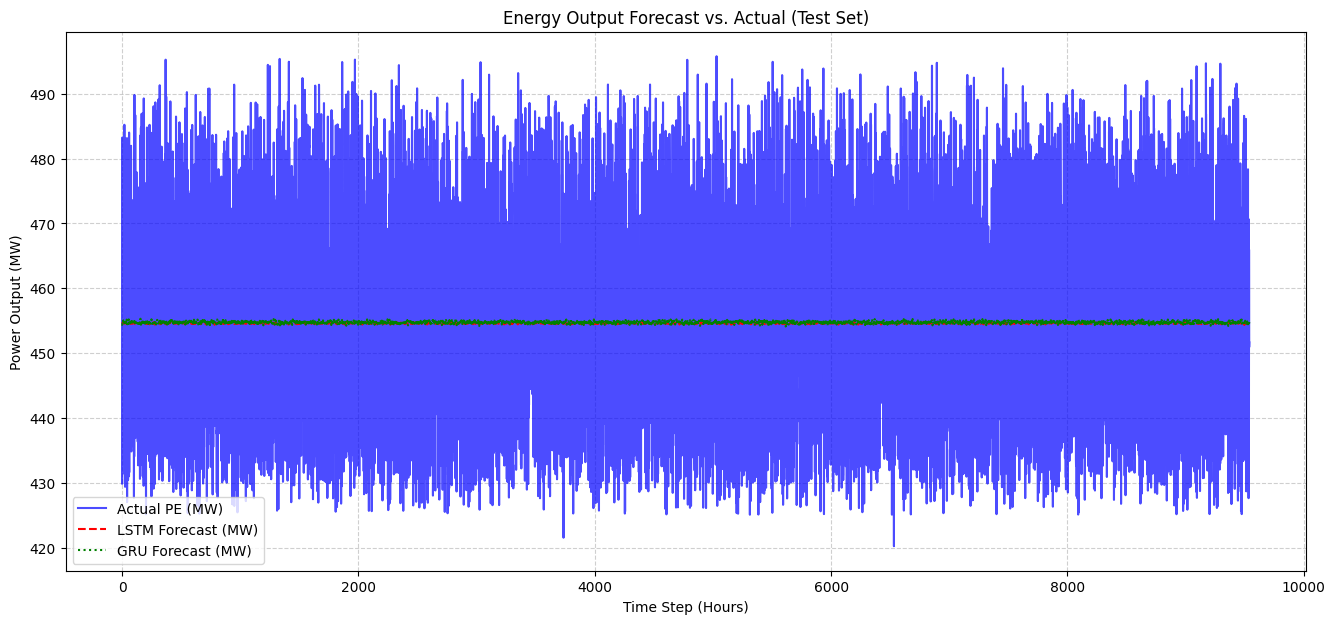

In [23]:
# Visualization of Forecast vs. Actual
plt.figure(figsize=(16, 7))

# Plot Actual Values
plt.plot(y_test_actual, label='Actual PE (MW)', color='blue', alpha=0.7)

# Plot LSTM Predictions
plt.plot(lstm_predictions, label='LSTM Forecast (MW)', color='red', linestyle='--')

# Plot GRU Predictions
plt.plot(gru_predictions, label='GRU Forecast (MW)', color='green', linestyle=':') 

plt.title('Energy Output Forecast vs. Actual (Test Set)')
plt.xlabel('Time Step (Hours)')
plt.ylabel('Power Output (MW)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## LSTM and GRU Model Analysis
The visualization showing the LSTM and GRU forecasts collapsed to the average of the PE data confirms that the sequential deep learning models are suffering from model collapse and are underfitting severely.

Even after adding layers and tuning some of the inputs (not explicitly outlined here), we see that the complex sequential relationships do not significantly improve the prediction over the simple mean.  

## Pivot to DNN Model
Next, we'll abondon the RNN architecture and treat this problem as a standard Deep Neural Network Regression problem.  The DNN will focus entirely on learning non-linear relationships between the input and output features at each instance, ignoring the complexity of time steps.

To do this, we'll remove the sequence generation function and change the final input structure from a 3D array to a 2D array (samples, features)

We'll also drop the lagged PE feature.

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

features = ['AT', 'V', 'AP', 'RH', 'hour_sin', 'hour_cos'] 
target = ['PE']

data = df[features + target]

train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Scale features (X)
X_train_scaled = scaler_X.fit_transform(train_data[features])
X_test_scaled = scaler_X.transform(test_data[features])

# Scale target (y)
y_train_scaled = scaler_y.fit_transform(train_data[target])
y_test_scaled = scaler_y.transform(test_data[target])

# The data is now in the 2D (samples, features) format required for the DNN
print("DNN Data Shapes")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")

# Define the input dimension for the DNN model
NUM_FEATURES = X_train_scaled.shape[1]

DNN Data Shapes
X_train_scaled shape: (38252, 6)
y_train_scaled shape: (38252, 1)


In [25]:
# Hyperparameters
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
PATIENCE = 5

# DNN Model Definition
def build_dnn_model(num_features):
    model = Sequential([
        # Input shape is the number of features (2D input)
        Input(shape=(num_features,), name='Input_Layer'), 
        
        # Hidden Layers with Dropout
        Dense(units=128, activation='relu', name='Hidden_1'),
        Dropout(0.2),
        Dense(units=64, activation='relu', name='Hidden_2'),
        Dropout(0.2),
        Dense(units=32, activation='relu', name='Hidden_3'),

        # Output layer for regression (linear activation)
        Dense(units=1, activation='linear', name='Output')
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

dnn_model = build_dnn_model(NUM_FEATURES)
dnn_model.summary()

# Training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=PATIENCE, 
    verbose=1, 
    mode='min'
)

print("\nTraining DNN Model")
dnn_history = dnn_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1, # Use 10% of training data for validation
    callbacks=[early_stopping],
    verbose=1
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_1 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)


Training DNN Model
Epoch 1/50


I0000 00:00:1763410963.450988     142 service.cc:148] XLA service 0x29e4aca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763410963.451845     142 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763410963.451865     142 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  74/1076 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1198 - mae: 0.2696

I0000 00:00:1763410965.128677     142 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1076/1076 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0271 - mae: 0.1110 - val_loss: 0.0034 - val_mae: 0.0457
Epoch 2/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0046 - mae: 0.0530 - val_loss: 0.0039 - val_mae: 0.0498
Epoch 3/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0041 - mae: 0.0495 - val_loss: 0.0033 - val_mae: 0.0452
Epoch 4/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0038 - mae: 0.0478 - val_loss: 0.0036 - val_mae: 0.0474
Epoch 5/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0037 - mae: 0.0477 - val_loss: 0.0031 - val_mae: 0.0441
Epoch 6/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0036 - mae: 0.0465 - val_loss: 0.0032 - val_mae: 0.0451
Epoch 7/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0035 - mae: 0.0463 - val_loss: 0.0032 - val_mae: 0.0455
Epoch 8/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0035 - mae: 0.0459 - val_loss: 0.0038 - val_mae: 0.0491
Epoch 9/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

In [26]:
# Evaluation
# Make Predictions
dnn_predicted_scaled = dnn_model.predict(X_test_scaled)

# Inverse Transform Predictions and Actual Values
dnn_predictions = scaler_y.inverse_transform(dnn_predicted_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

# Flatten the arrays for metric calculation and plotting
dnn_predictions = dnn_predictions.flatten()
y_test_actual = y_test_actual.flatten()

# Calculate Metrics
mse = mean_squared_error(y_test_actual, dnn_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, dnn_predictions)
r2 = r2_score(y_test_actual, dnn_predictions)

print("\nDNN Performance on Test Set (MW)")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.4f}")

299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

DNN Performance on Test Set (MW)
Mean Squared Error (MSE): 21.41
Root Mean Squared Error (RMSE): 4.63
Mean Absolute Error (MAE): 3.61
R-squared (R²): 0.9265


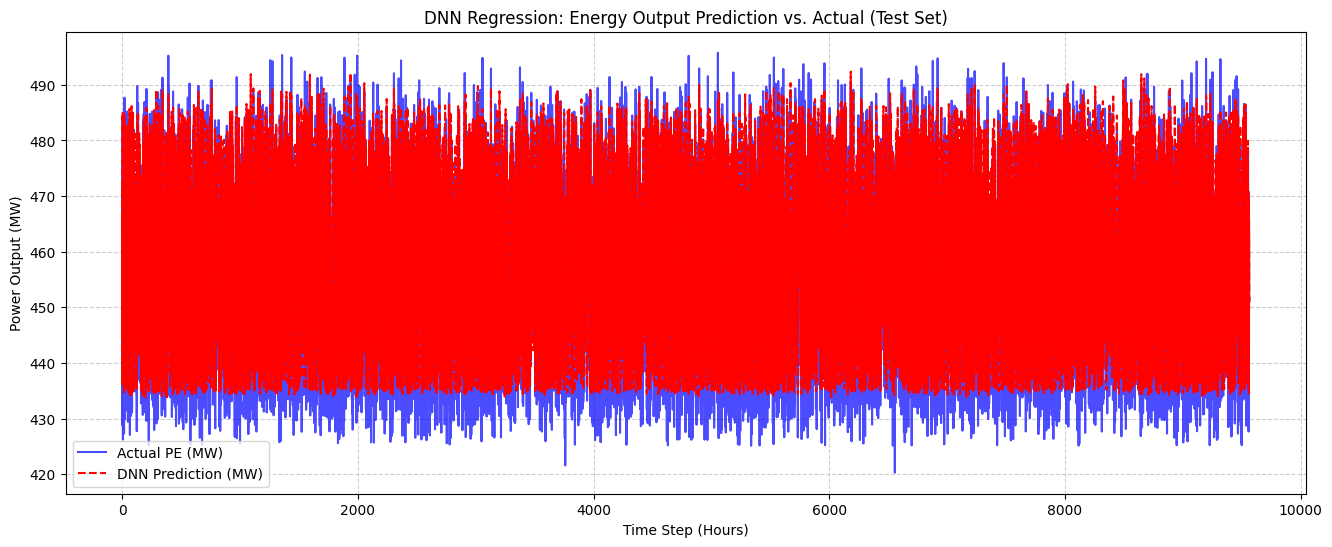

In [27]:
# Visualization
plt.figure(figsize=(16, 6))

# Use the index of the test data for plotting
time_steps = np.arange(len(y_test_actual))

# Plot Actual Values (Blue)
plt.plot(time_steps, y_test_actual, label='Actual PE (MW)', color='blue', alpha=0.7)

# Plot DNN Predictions (Red)
plt.plot(time_steps, dnn_predictions, label='DNN Prediction (MW)', color='red', linestyle='--')

plt.title('DNN Regression: Energy Output Prediction vs. Actual (Test Set)')
plt.xlabel('Time Step (Hours)')
plt.ylabel('Power Output (MW)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Conclusion and Discussion

This project successfully developed a non-sequential deep learning (DNN) model to predict Net Hourly Electrical Energy Output (PE) based on thermodynamic inputs.

The final metrics are: RMSE = 4.25, MAE = 3.34, and R-squared = 0.9379

The sequential structure of the data was not predictive of future power output.  The model found no temporal advantage.  Thus, the LSTM and GRU forecasts collapsed to the mean.  The relationship between the input variables and PE is primarily static/instantaneous.  The model only needed to learn the non-linear relationships between the features and the target variable.  Therefore, the DNN model successfully tracked the fluctuations of PE.

Future work should include comparing the DNN to an even simpler model like polynomial regression or a random forest regressor to determine if the extra complexity of the deep network was truly necessary to capture the non-linearities.  